<a href="https://colab.research.google.com/github/RealB1ackY/ISnT_Lab11-12/blob/main/ClusterAnalyzWithOop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install apriori_python efficient-apriori fpgrowth_py pyarmviz numpy pandas matplotlib seaborn scikit-learn matplotlib umap-learn imblearn fuzzy-c-means
import numpy as np
import random
import pandas as pd
import seaborn as sns
import warnings

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from umap import UMAP
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
# decision tree evaluated on imbalanced dataset with SMOTE oversampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import *
from sklearn.metrics import *
from fcmeans import *
from scipy.cluster.hierarchy import *
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import *

import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class Analysis:
    df = None
    X = pd.DataFrame()
    y = pd.Series()
    scaled_data = None
    WCSS = []
    Silh_K = []
    Silh_C = []
    n_samples = None
    n_features = None
    target_names = None
    labels = None
    n_clusters_ = None
    n_noise_ = None
    core_samples_mask = None
    eps = None


    @classmethod
    def init(cls, df_path="data/admission_basedon_exam_scores.csv", eps=0.45):
        cls.df = pd.read_csv(df_path)
        cls.X = cls.df[cls.df.columns[1:-1]]
        cls.y = cls.df[cls.df.columns[-1]]
        cls.n_samples = len(cls.y.values)
        cls.n_features = len(cls.df.columns[:-1])
        cls.target_names = {1: 'class 1', 2: 'class 2', 3: 'class 3', 5: 'class 5', 6: 'class 6', 7: 'class 7'}
        # cls.scaled_data = MinMaxScaler().fit_transform(cls.X)
        cls.scaled_data = np.array(cls.X)
        cls.eps=eps

        cls.WCSS = []
        cls.Silh_K = []
        for i in range(2, 11):
            kmeans = KMeans(n_clusters=i, init="k-means++",
                            max_iter=len(cls.y), n_init=10)
            kmeans.fit(cls.scaled_data)
            predicted = kmeans.fit_predict(cls.scaled_data)
            cls.WCSS.append(kmeans.inertia_)
            cls.Silh_K.append(silhouette_score(cls.scaled_data, predicted, metric="euclidean"))


        for i in range(2, 11):
            fcm = FCM(n_clusters=i, m=2, max_iter=len(cls.y), random_state=0)
            fcm.fit(cls.scaled_data)
            predicted = fcm.predict(cls.scaled_data)
            cls.Silh_C.append(silhouette_score(cls.scaled_data, predicted, metric="euclidean"))

        db = DBSCAN(eps=cls.eps, min_samples=5).fit(cls.scaled_data)
        cls.core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        cls.core_samples_mask[db.core_sample_indices_] = True
        cls.labels = db.labels_

        cls.n_clusters_ = len(set(cls.labels)) - (1 if -1 in cls.labels else 0)
        cls.n_noise_ = list(cls.labels).count(-1)


    @classmethod
    def hierarchy_cluster_analysis(cls,  method_type):
        distance_matrix = linkage(cls.scaled_data, method=method_type, metric="euclidean")
        # print(distance_matrix, end="\n\n")
        fig = plt.figure(figsize=(15, 30))
        plt.title(f"{method_type}", fontsize="16")
        fig.patch.set_facecolor("white")
        dendrogram(distance_matrix,
                labels=[cls.target_names[i] for i in cls.y],
                orientation="left",
                leaf_font_size=4)


        claster_labels = fcluster(distance_matrix, 2, criterion="distance")
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].scatter(cls.scaled_data[:, 0], cls.scaled_data[:, 1],
                        c=cls.y)
        axes[1].scatter(cls.scaled_data[:, 0], cls.scaled_data[:, 1],
                        c=claster_labels, cmap="Set1")
        axes[0].set_title(f"Реальные метки кластеров {method_type}", fontsize=16)
        axes[1].set_title(f"Метки кластеров, найденные алгоритмом {method_type}", fontsize=16)
        plt.show()

    @classmethod
    def silh_and_elbow_visualisation(cls, method_type: list):
        plt.figure(figsize=(5, 5))
        try:
            plt.plot(range(2, 11), method_type)
        except:
            print("\n\nERRRRRRORRRRRR\n\n",list)

        plt.xlabel("Число кластеров")
        if method_type == cls.Silh_K:
            plt.title("Индекс кластерного силуэта (Silhouette score)")
            plt.ylabel("Silhouette score k-means")
        elif method_type == cls.WCSS:
            plt.title("Метод локтя (elbow method)")
            plt.ylabel("WCSS")
        elif method_type == cls.Silh_C:
            plt.title("Индекс кластерного силуэта (Silhouette score)")
            plt.ylabel("Silhouette score c-means")
        plt.show()

    @classmethod
    def silhouette_score_visualisation(cls, method_type):
        kmeans = KMeans(n_clusters = len(set(cls.y)))
        kmeans.fit(cls.scaled_data)
        fcm = FCM(n_clusters=len(set(cls.y)))
        fcm.fit(cls.scaled_data)
        if method_type == cls.Silh_K:
            predicted = kmeans.fit_predict(cls.scaled_data)
        elif method_type == cls.Silh_C:
            predicted = fcm.predict(cls.scaled_data)
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        axes[0].scatter(cls.scaled_data[:, 0], cls.scaled_data[:, 1],
                        c=cls.y)
        axes[0].scatter(kmeans.cluster_centers_[0:, 0],
                        kmeans.cluster_centers_[0:, 1],
                        s=100, c="black", label="Centroids")
        if method_type == cls.Silh_K:
            axes[0].set_title("Реальные метки кластеров k-means", fontsize=16)
        elif method_type == cls.Silh_C:
            axes[0].set_title("Реальные метки кластеров c-means", fontsize=16)
        axes[1].scatter(cls.scaled_data[0:, 0], cls.scaled_data[0:, 1],
                        c=predicted, cmap="Set1")
        axes[1].scatter(kmeans.cluster_centers_[0:, 0],
                        kmeans.cluster_centers_[0:, 1],
                        s=100, c="black", label="Centroids")
        if method_type == cls.Silh_K:
            axes[1].set_title("Метки классов, найденные алгоритмом k-means", fontsize=16)
        elif method_type == cls.Silh_C:
            axes[1].set_title("Метки классов, найденные алгоритмом c-means", fontsize=16)
            plt.show()

    @classmethod
    def calculate_kn_distance(cls, k):
        kn_distance = []
        for i in range(len(cls.X)):
            eucl_dist = []
            for j in range(len(cls.X)):

                eucl_dist.append(
                    math.sqrt(
                        ((cls.X.values[i, 0] - cls.X.values[j, 0]) ** 2) +
                        ((cls.X.values[i, 1] - cls.X.values[j, 1]) ** 2)))
            eucl_dist.sort()
            kn_distance.append(eucl_dist[k])

        return kn_distance

    @classmethod
    def eps_gistogramm(cls):
        eps_dist = cls.calculate_kn_distance(5)
        plt.hist(eps_dist, bins=30)
        plt.ylabel("Число объектов", size=14)
        plt.xlabel("Eps расстояние", size=14)
        plt.show()

    @classmethod
    def dbscan_cluster(cls):
        pred_y = DBSCAN(eps=cls.eps, min_samples=5).fit_predict(cls.scaled_data)
        print("Число кластеров: %d" % cls.n_clusters_)
        print("Число шумовых объектов: %d" % cls.n_noise_)
        print("Homogeneity: %0.3f" % sklearn.metrics.homogeneity_score(pred_y, cls.y))
        print("Completeness: %0.3f" % sklearn.metrics.completeness_score(pred_y, cls.y))
        print("V-measure: %0.3f" % sklearn.metrics.v_measure_score(pred_y, cls.y))
        print("Adjusted Rand Index: %0.3f" % sklearn.metrics.adjusted_rand_score(pred_y, cls.y))
        print("Adjusted Mutual Information: %0.3f" % sklearn.metrics.adjusted_mutual_info_score(pred_y, cls.y))
        print("Silhouette Score: %0.3f" % sklearn.metrics.silhouette_score(pred_y.reshape(-1, 1), cls.y))

    @classmethod
    def dbscan_visualisation(cls):
        plt.figure(figsize=(8, 8))
        unique_labels = list(set(cls.labels))
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                col = [0, 0, 0, 1]
            class_member_mask = cls.labels == k
            xy = cls.scaled_data[class_member_mask & cls.core_samples_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=14
            )

            xy = cls.scaled_data[class_member_mask & cls.core_samples_mask]
            plt.plot(
                xy[:, 0],
                xy[:, 1],
                "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=6
            )

        plt.title("Число кластеров: %d" % cls.n_clusters_, size=14)
        plt.show()


<ipython-input-73-398a75fe2f31>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y = pd.Series()


   1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.00.1  1.1
0  2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83   0.0    0.00    1
1  3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78   0.0    0.00    1
2  4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22   0.0    0.00    1
3  5  1.51742  13.27  3.62  1.24  73.08  0.55  8.07   0.0    0.00    1
4  6  1.51596  12.79  3.61  1.62  72.97  0.64  8.07   0.0    0.26    1

(array([1, 2, 3, 5, 6, 7]), array([69, 76, 17, 13,  9, 29]))

{1: 'class 1', 2: 'class 2', 3: 'class 3', 5: 'class 5', 6: 'class 6', 7: 'class 7'}

                0           1           2           3           4           5  \
count  213.000000  213.000000  213.000000  213.000000  213.000000  213.000000   
mean     1.518353   13.406761    2.676056    1.446526   72.655023    0.499108   
std      0.003039    0.818371    1.440453    0.499882    0.774052    0.653035   
min      1.511150   10.730000    0.000000    0.290000   69.810000    0.000000   
25%      1.516520   

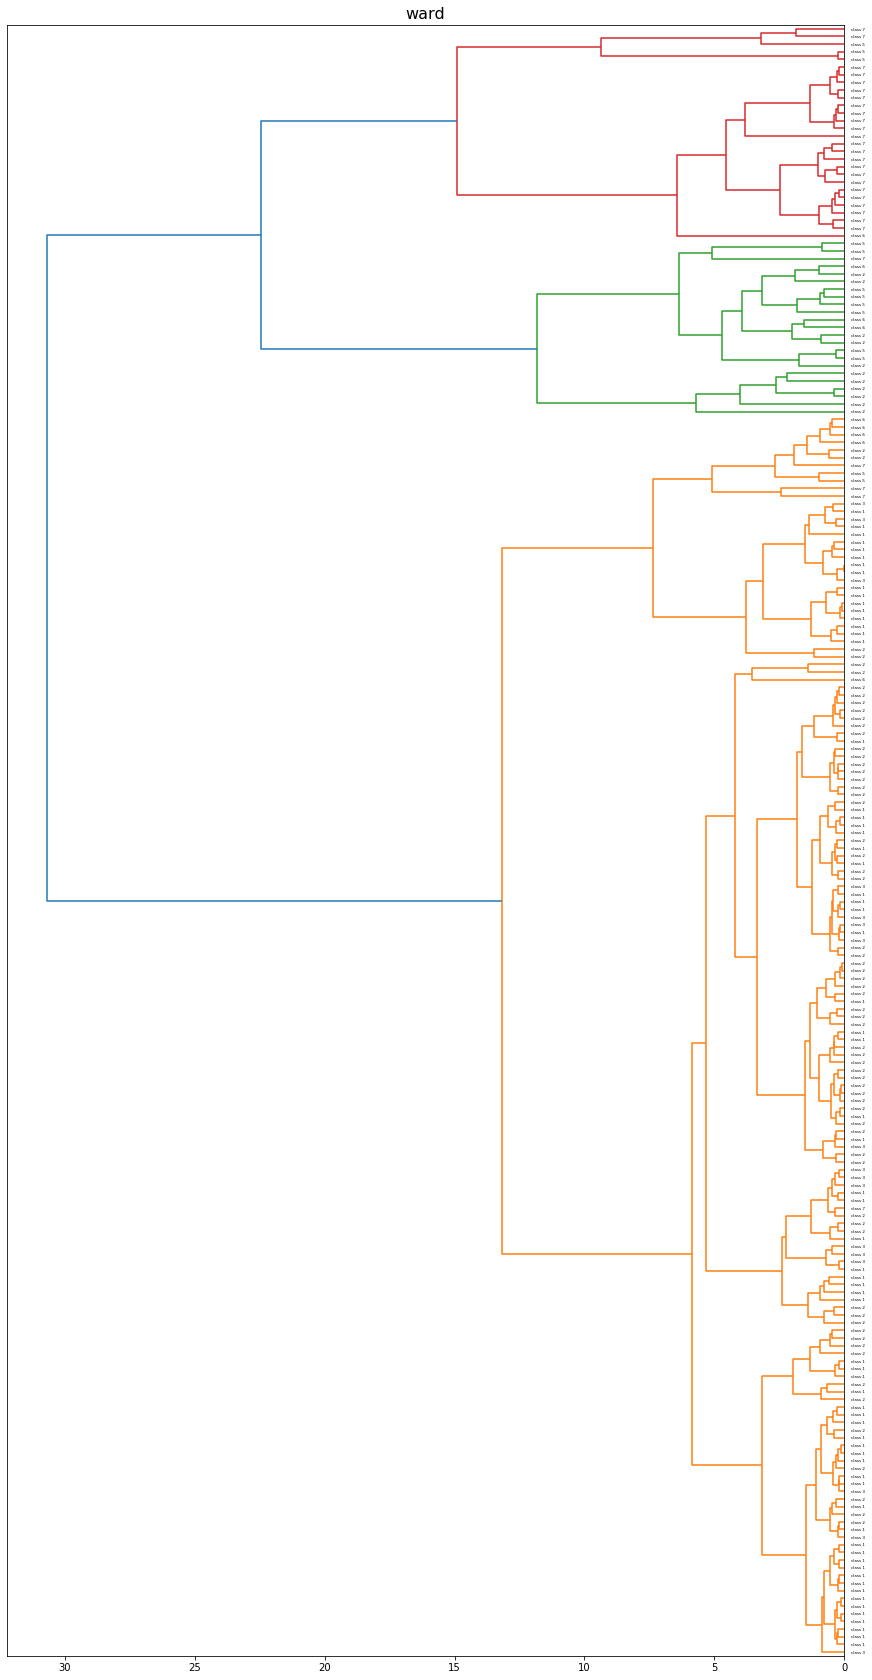

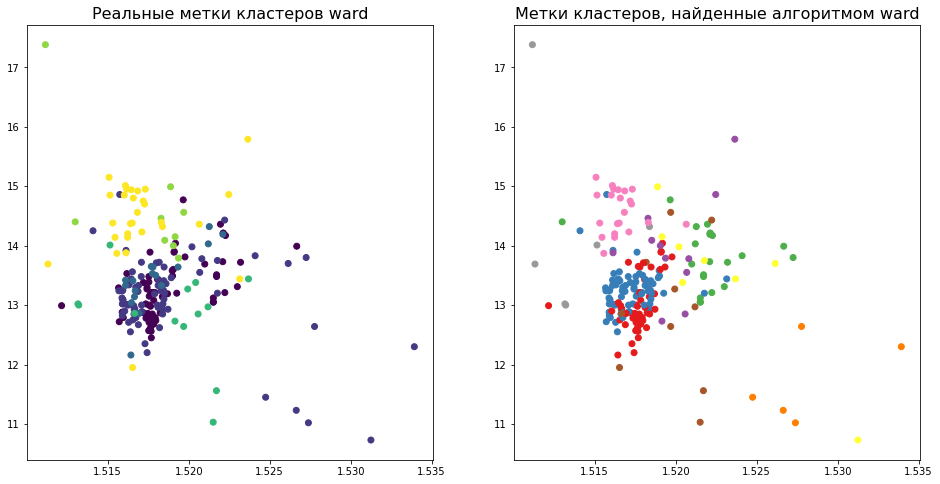

single method



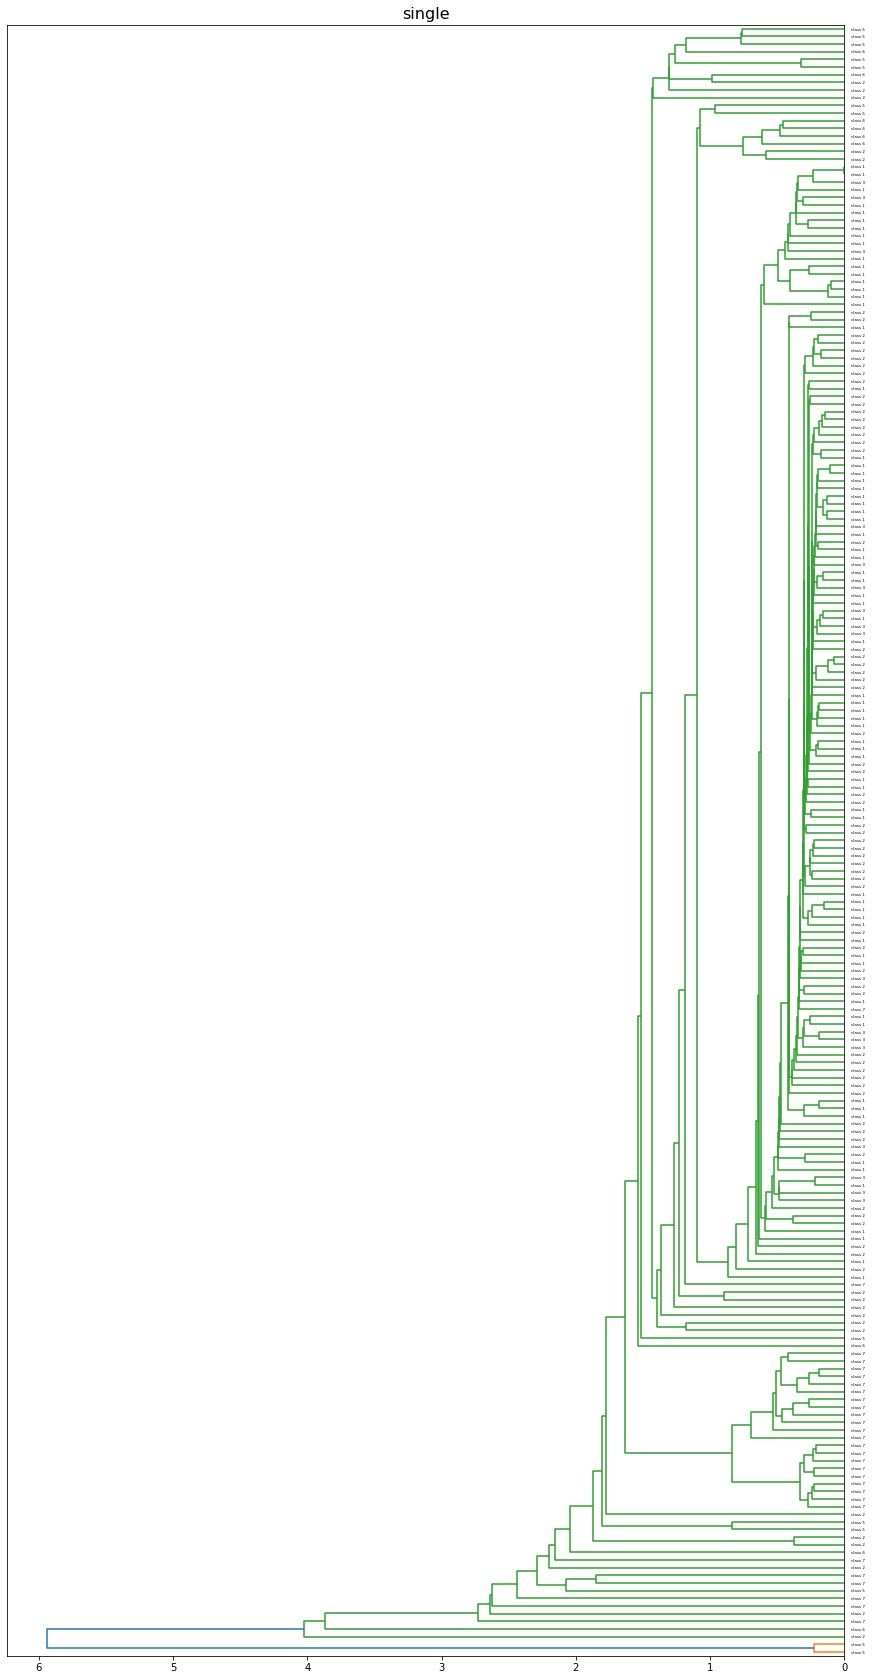

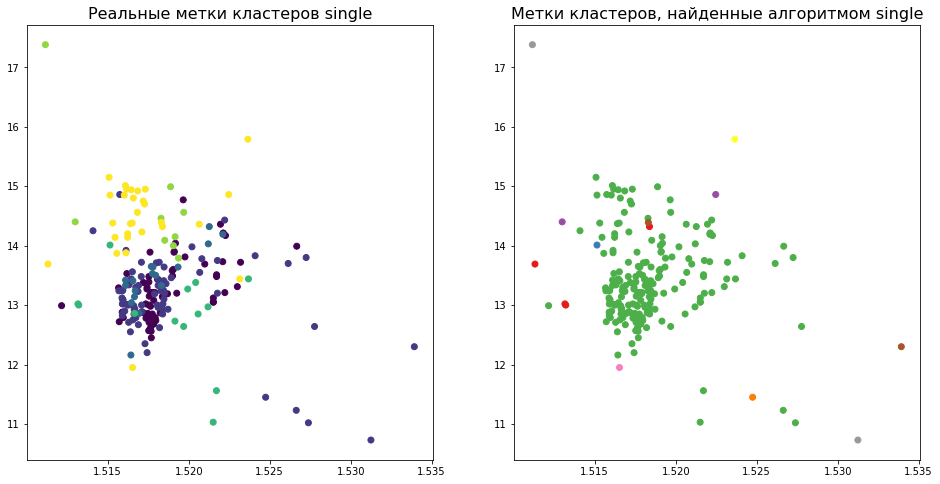

complete method



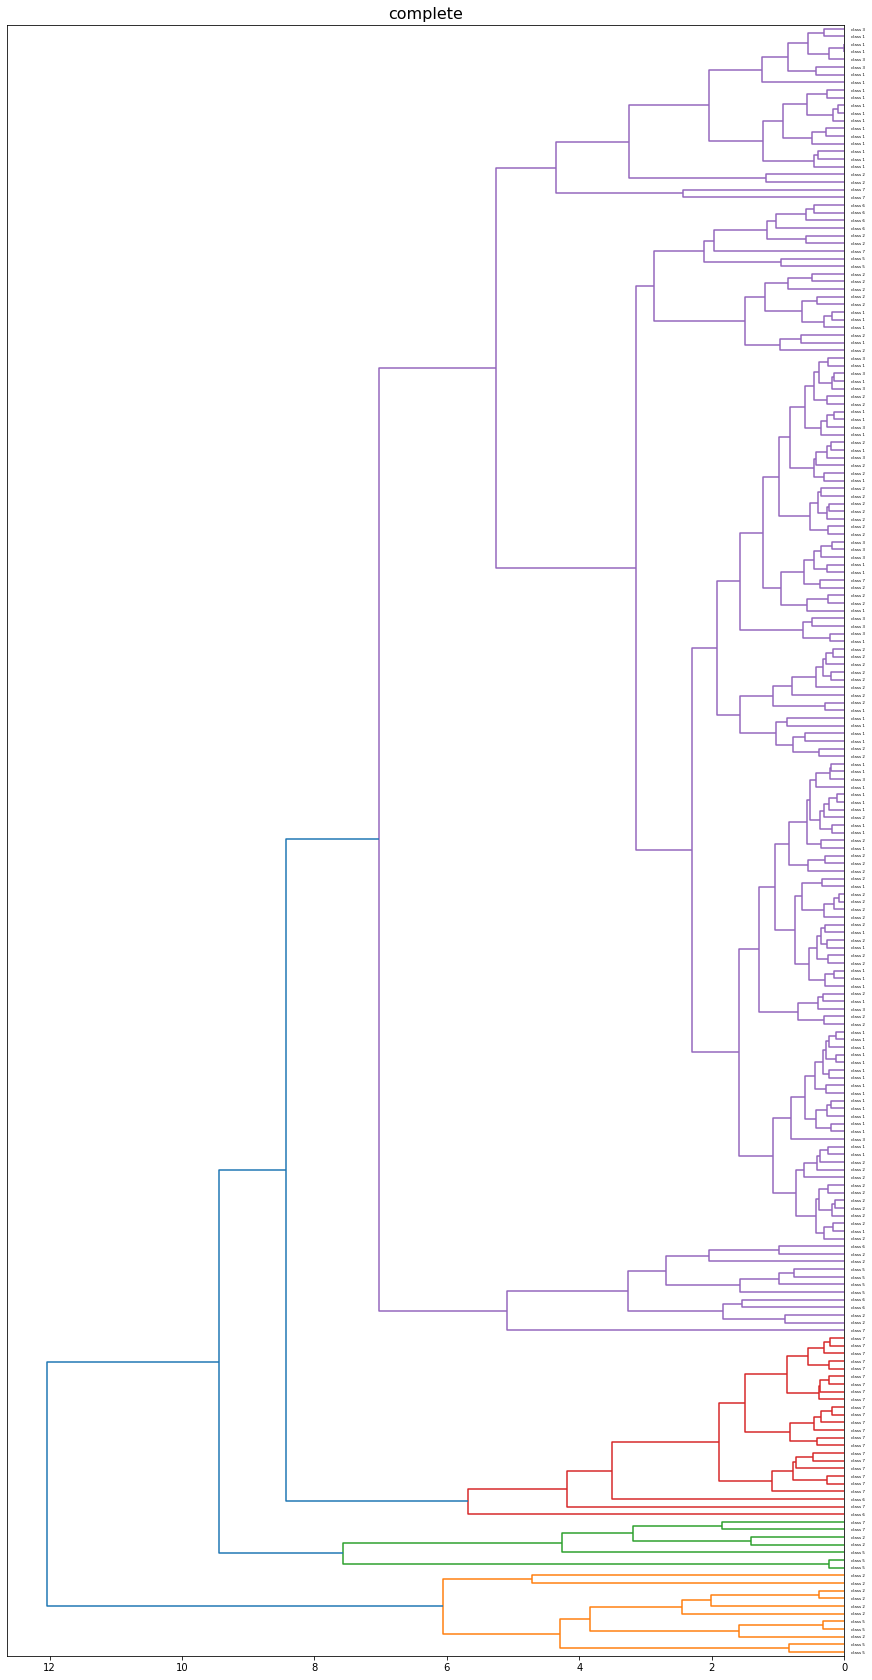

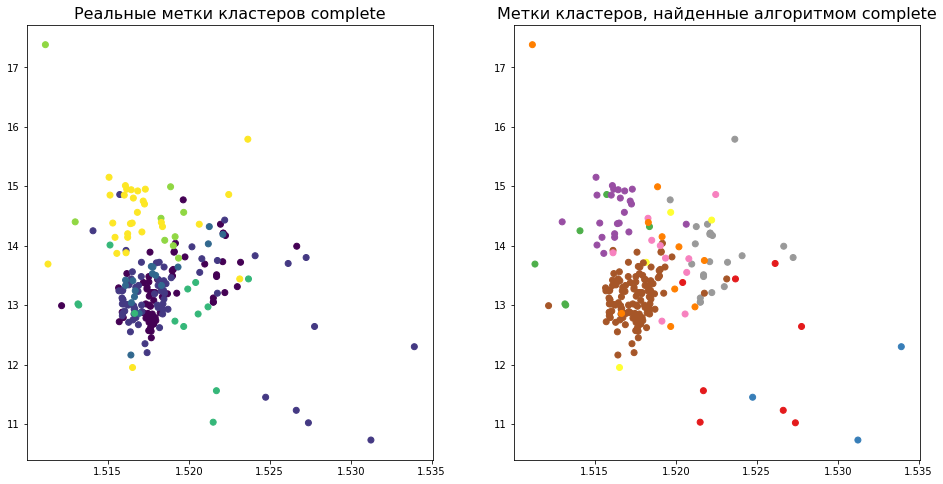

average method



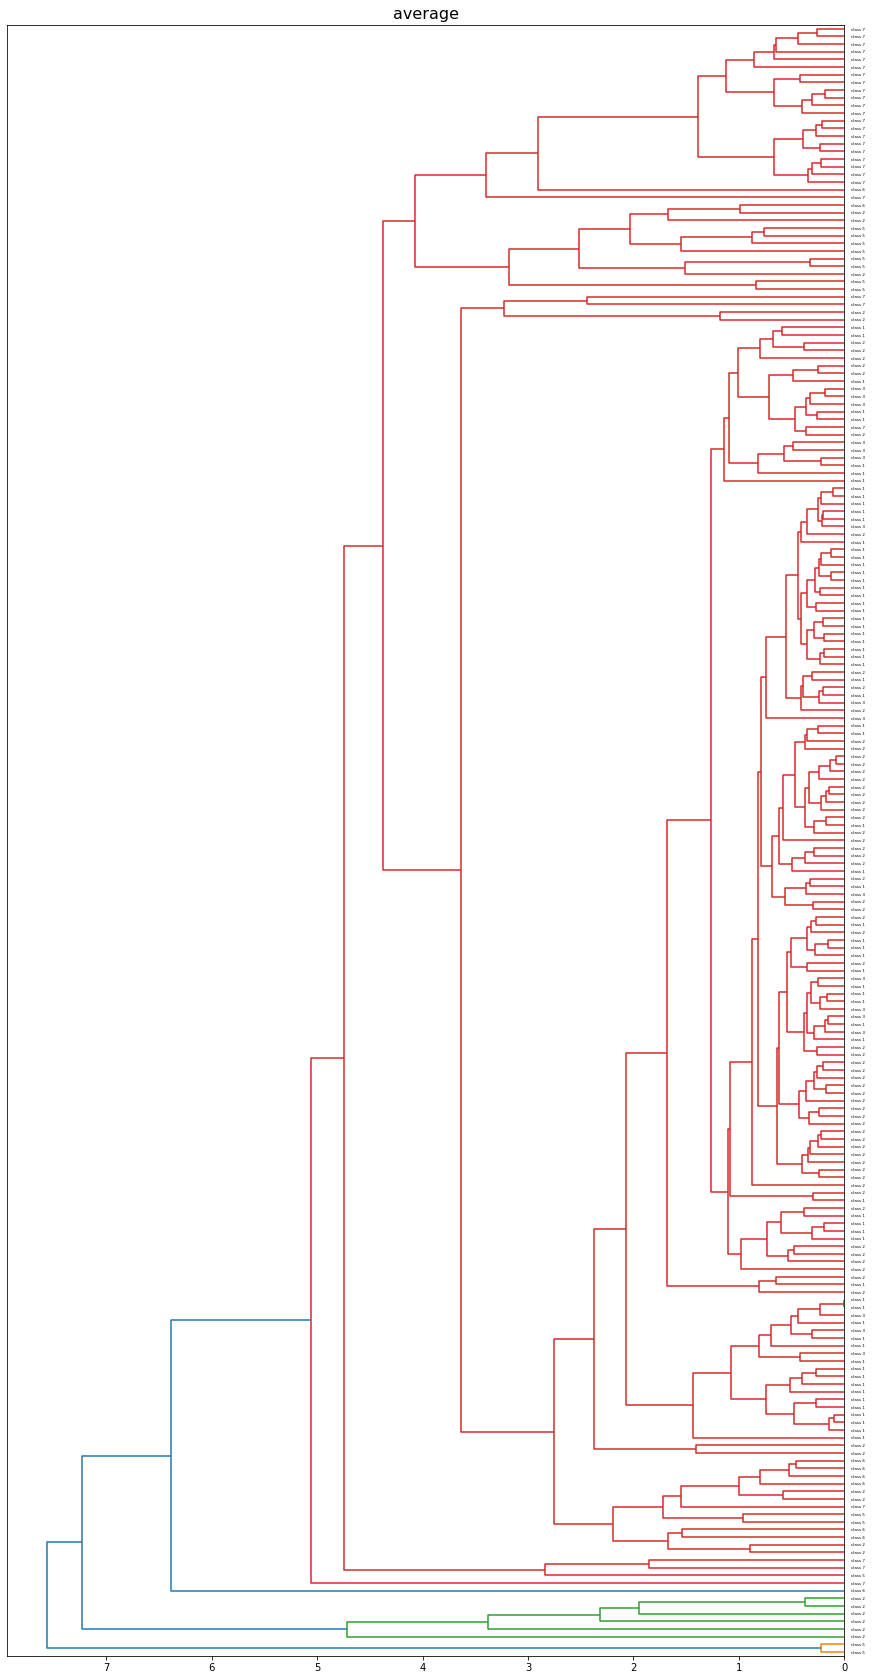

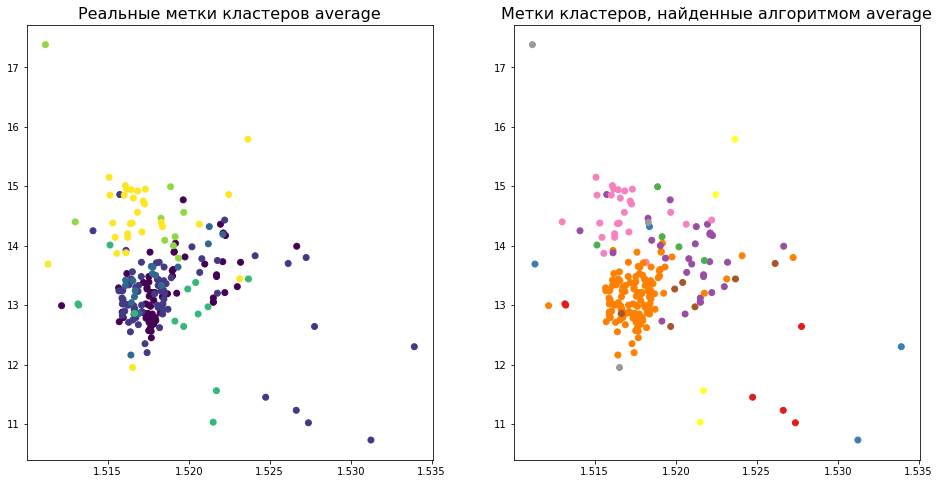

Silh, k-means
0.5602613464797124
0.5821748610893649
0.42988974196449065
0.44223830641388084
0.44780173880050916
0.451011569120639
0.4604766362819285
0.2837910493626295
0.3071163247350172



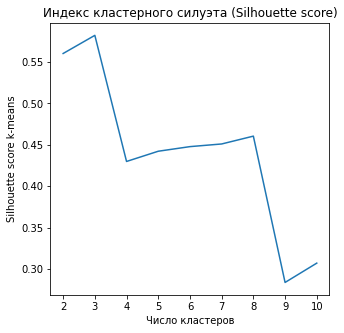

Silh, c-means
0.5544788924219957
0.5821229269310101
0.3867850611130054
0.23806821726049493
0.24116913857846847
0.22753270287944333
0.20357692615339026
0.22380668566541997
0.20823637057895006



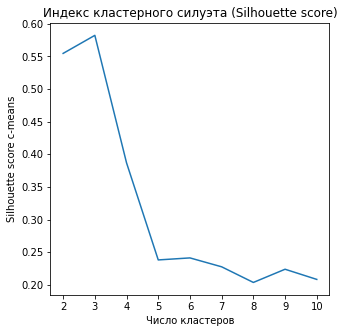

WCSS
817.4839495585654
586.8587377527349
495.6276854400324
399.3399661486986
336.6329624514951
290.3923686978332
265.0182158721832
245.98013788545722
223.9496115336741



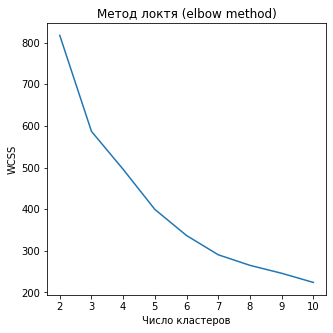

Визуализация Silh k-means
Визуализация Silh c-means


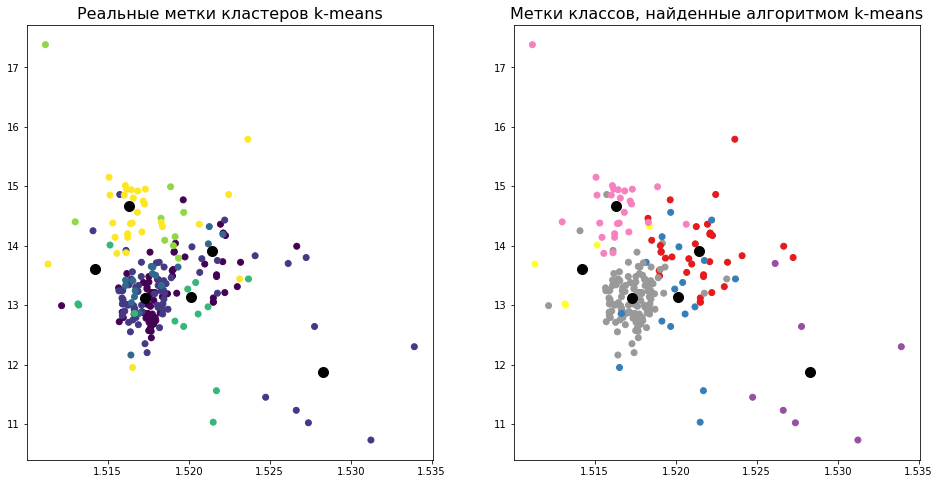

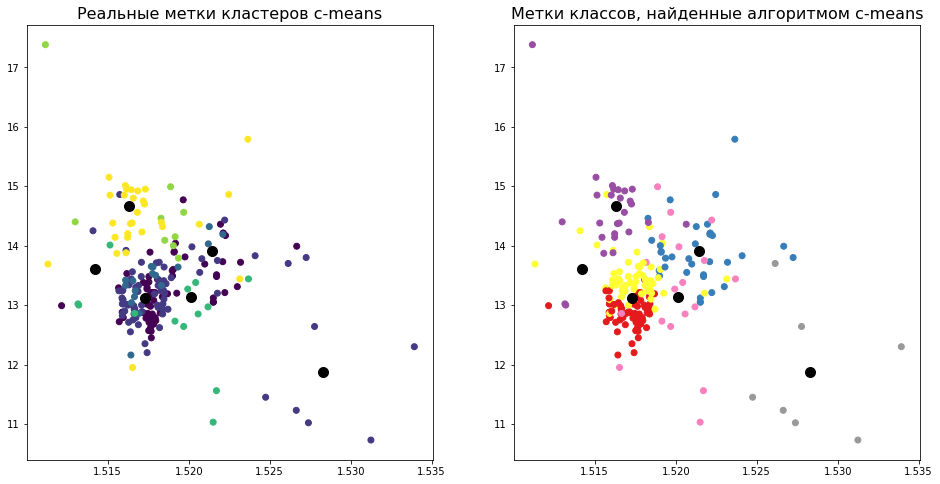

Визуализация EPS-гистограммы


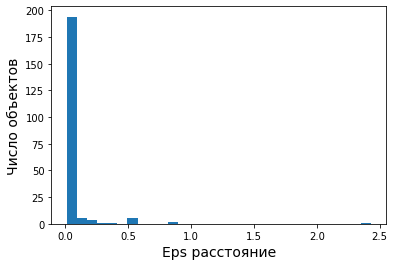

Кластеризация DBSCAN

Число кластеров: 4
Число шумовых объектов: 63
Homogeneity: 0.402
Completeness: 0.309
V-measure: 0.349
Adjusted Rand Index: 0.192
Adjusted Mutual Information: 0.323
Silhouette Score: -0.180
Визуализация DBSCAN



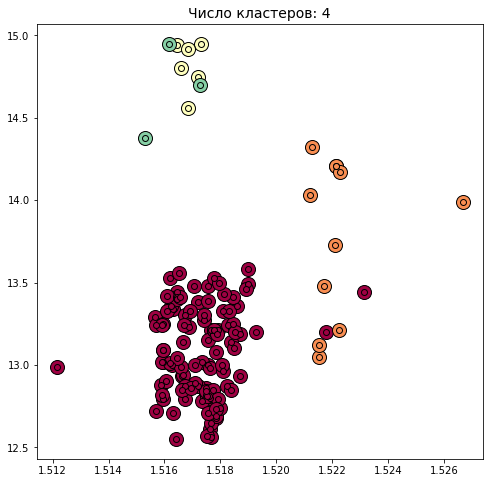

In [ ]:
Analysis.init("/content/sample_data/glass.data", eps=.55)


print(Analysis.df.head(), end="\n\n")
print(np.unique(Analysis.y, return_counts=True), end="\n\n")
print(Analysis.target_names, end="\n\n")

print(pd.DataFrame(Analysis.scaled_data).describe(), end="\n\n\n")

print("ward method\n")
Analysis.hierarchy_cluster_analysis("ward")
print("single method\n")
Analysis.hierarchy_cluster_analysis("single")
print("complete method\n")
Analysis.hierarchy_cluster_analysis("complete")
print("average method\n")
Analysis.hierarchy_cluster_analysis("average")
print("Silh, k-means", *Analysis.Silh_K, sep="\n", end="\n\n")
Analysis.silh_and_elbow_visualisation(Analysis.Silh_K)
print("Silh, c-means", *Analysis.Silh_C, sep="\n", end="\n\n")
Analysis.silh_and_elbow_visualisation(Analysis.Silh_C)
print("WCSS", *Analysis.WCSS, sep="\n", end="\n\n")
Analysis.silh_and_elbow_visualisation(Analysis.WCSS)
print("Визуализация Silh k-means")
Analysis.silhouette_score_visualisation(Analysis.Silh_K)
print("Визуализация Silh c-means")
Analysis.silhouette_score_visualisation(Analysis.Silh_C)
print("Визуализация EPS-гистограммы")
Analysis.eps_gistogramm()
print("Кластеризация DBSCAN", end="\n\n")
Analysis.dbscan_cluster()
print("Визуализация DBSCAN\n")
Analysis.dbscan_visualisation()


